# Well placement optimization with PyMRST

The aim of this notebook is to run optimization to search the best locations of water injection wells in an oil waterflooding simulation

## Setup

PyMRST is in GitHub. We need to clone the repository to use it.

In [1]:
# Clone pyMRST
!git clone https://github.com/yohanesnuwara/pyMRST

Cloning into 'pyMRST'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 342 (delta 110), reused 159 (delta 80), pack-reused 132 (from 1)
Receiving objects: 100% (342/342), 2.14 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (156/156), done.


Import necessary Python libraries (NumPy, Matplotlib) and PyMRST modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Add directory where you install PyMRST
import sys
sys.path.append("/content/pyMRST")

import pymrst
from pymrst_units import *

Setup PyMRST. The setup will do installation of MATLAB-Octave in Google Colab and cloning the original MRST repositories in their BitBucket.  

In [3]:
# Setup PyMRST (Takes about 1 minute)
pymrst.setup()

Now, we can start using Python syntaxes to run MRST. All set!

## Create models

As usual, we create reservoir static model, fluid model, boundary condition, well, and time steps. See the other notebook on [Waterflooding](https://github.com/yohanesnuwara/pyMRST/blob/main/notebooks/pyMRST_oilwaterflooding.ipynb) (See Simulation 1) to understand the workflow.

In [4]:
# Use SPE10 model. Use Python dictionary.
model = dict({"name": "spe10",
              "nlayer": 10,
              "startlayer": 4})

In [5]:
# Rock property
rock = dict({"c": 1e-6*(1/1e+5), # Rock compressibility at ref pressure, 1/bar to 1/Pa
             "p_r": 200*1e+5}) # Reference pressure, bar to Pa

In [6]:
# Fluid property: 2-phase oil-water
fluid = dict({"type": ["water", "oil"],
              "mu": [1*centi()*poise(), 1*centi()*poise()],
              "rho": [1000, 850],
              "n": [2, 2]}) # Corey exponent

In [7]:
# Boundary
bc_front = dict({"type": "fluxside", "value": 0}) # bbl/d to m3/s
bc_back = dict({"type": "fluxside", "value": 0})
bc_left = dict({"type": "fluxside", "value": 0}) # m3/d to m3/s
bc_right = dict({"type": "pside", "value": 0}) # bar to Pa

Input well operating conditions. 4 water injectors in the corners and 1 oil producer in the middle. Note the 4 wells have coordinates that will be optimized.

|Well|Status|Cell location|BC|Radii|Skin|
|:--:|:--:|:--:|:--:|:--:|:--:|
|I|Water injector|(x1,y1)|BHP 200 bar|.125 m|0|
|II|Water injector|(x2,y2)|BHP 200 bar|.125 m|0|
|III|Water injector|(x3,y3)|BHP 200 bar|.125 m|0|
|IV|Water injector|(x4,y4)|BHP 200 bar|.125 m|0|
|V|Oil producer|(30,111)|BHP 100 bar|.125 m|0|

In [8]:
# Well
types = np.full(5, "bhp")
values = np.array([200, 200, 200, 200, 100])*barsa()
radii = np.full(5, .125)*meter()
skins = np.full(5, 0)
directions = np.full(5, None) # Vertical well is None
phases = np.array([[1,0], [1,0], [1,0], [1,0], [0,1]])

In [9]:
# Time step
numSteps, totTime = 3, 5*365 # 20 years
steps = [1,2,3]

In [10]:
# Arrange the input
input = {
    "model": model,
    "rock": rock,
    "fluid": fluid,
    "bc_front": bc_front,
    "bc_back": bc_back,
    "bc_left": bc_left,
    "bc_right": bc_right,
    "totTime": totTime,
    "numSteps": numSteps,
    "steps": steps,
    "well_properties": {
        "type": types.tolist(),
        "value": values.tolist(),
        "radius": radii.tolist(),
        "skin": skins.tolist(),
        "direction": directions.tolist(),
        "phase": phases.tolist()
    }
}

## Create objective function

In [11]:
def objective(x1, y1, x2, y2, x3, y3, x4, y4):
  """
  Objective function
  """
  # Round the number given by the optimizer
  x1, y1, x2, y2 = np.round(x1), np.round(y1), np.round(x2), np.round(y2)
  x3, y3, x4, y4 = np.round(x3), np.round(y3), np.round(x4), np.round(y4)

  # Define well coordinates
  locs = np.array([[x1,  x2,  x3,  x4,   30],
                   [y1,  y2,  y3,  y4,  111],
                   [1,  1,  1,    1,    1]])
  well = dict({"cellx_loc": locs[0,:],
              "celly_loc": locs[1,:],
              "cellz_loc": locs[2,:],
              "type": types,
              "value": values,
              "phase": phases,
              "radius": radii,
              "skin": skins,
              "direction": directions})

  pymrst.model_input(model, fluid, well, bc_front, bc_back, bc_left, bc_right,
                numSteps, totTime, steps)

  # run simulation
  pymrst.run_simulation()

  # Get Np from txt
  Np = np.loadtxt('/content/result_oilwater_2phase/Np.txt').item()

  return Np

Test the objective function

In [12]:
objective(1,1,60,1,1,220,60,220)

15660.0

Create the search bound for well coordinates

In [13]:
pbounds = {"x1": (1, 30), "y1": (1, 111),
           "x2": (30, 60), "y2": (1, 111),
           "x3": (1, 30), "y3": (111,220),
           "x4": (30, 60), "y4": (111,220)}

Run Bayesian optimization

In [ ]:
pymrst.optimize(objective, pbounds)

|   iter    |  target   |    x1     |    y1     |    x2     |    y2     |    x3     |    y3     |    x4     |    y4     |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 103140.0  | 11.861663 | 105.57857 | 51.959818 | 66.852433 | 5.5245405 | 128.00340 | 31.742508 | 205.41319 |


Run the simulation with optimized well locations

In [ ]:
objective(14.18,89.53 ,45.79,23.22,1.645,119.5,55.46,145.4)

120910.0

Visualize the new location of wells

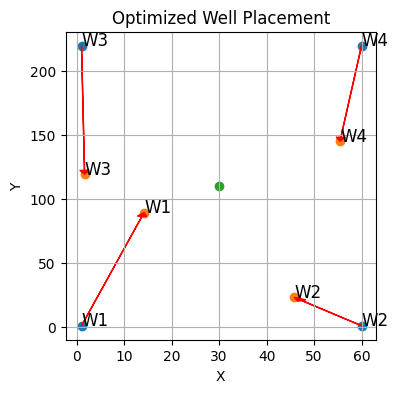

In [ ]:
import matplotlib.pyplot as plt

# Data
x = [1, 60, 1, 60]
y = [1, 1, 220, 220]
x1 = [14.18, 45.79, 1.645, 55.46]
y1 = [89.53, 23.22, 119.5, 145.4]

plt.figure(figsize=(4,4))

# Scatter plot for the first set of points
plt.scatter(x, y)

# Scatter plot for the second set of points
plt.scatter(x1, y1)

plt.scatter(30,110)

# Annotate points for the first set
texts = ["W1", "W2", "W3", "W4"]
for i, txt in enumerate(texts):
    plt.text(x[i], y[i], txt, fontsize=12)

# Annotate points for the second set
for i, txt in enumerate(texts):
    plt.text(x1[i], y1[i], txt, fontsize=12)

# Draw arrows
for i in range(len(x)):
    plt.arrow(x[i], y[i], x1[i] - x[i], y1[i] - y[i], color='red', head_width=2, length_includes_head=True)

# Add labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Optimized Well Placement')
plt.grid()
# Show plot
plt.show()


Visualize the oil saturation distribution with the enhanced well location

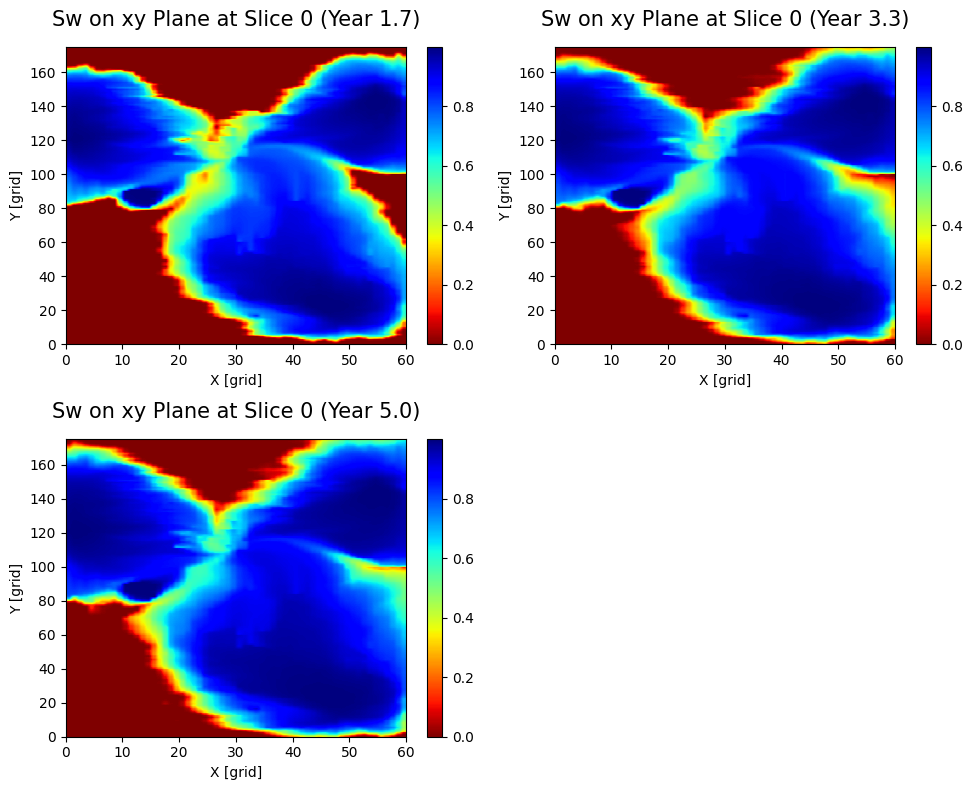

In [ ]:
from pymrst_units import *

# Specify dimension
nlayer = model["nlayer"]
dimension = (60,220,nlayer)

# Plane and layer number
plane, position = "xy", 0

# numSteps, totTime = 50, 20*365 # day
# steps = [2, 10, 20, 50]

# Plot Sw for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oilwater_2phase/"
  filename = "Sw{}.mat".format(steps[i])

  # Get cell data
  cube = pymrst.getCellData(directory, filename, dimension=dimension)

  # Plot for every timestep
  days = totTime / numSteps * steps[i]
  years = days * day() / year()

  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="jet_r")
  plt.title("Sw on {} Plane at Slice {} (Year {:.1f})".format(plane, position, years),
            size=15, pad=15)
  plt.ylim(0,175)
plt.tight_layout()
plt.show()